### 라이브러리 호출

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, f1_score

# 1. 데이터 추출

### 데이터 불러오기

In [3]:
app = pd.read_csv("application_record.csv")
crd = pd.read_csv("credit_record.csv")

app.info()
print("\n")
crd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

### 연체 데이터로부터 신용평가

In [4]:
crd_label = crd.drop('MONTHS_BALANCE', axis=1) # 연체 시점 정보 제거
crd_label['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True) # C(상환)과 X(대출없음)을 0개월 연체로 취급
crd_label['STATUS'] = crd_label['STATUS'].astype('int') # object -> int
crd_label['STATUS'] = crd_label['STATUS'].apply(lambda x:1 if x >= 2 else 0) # 60일 이상 연체: 1(Bad)
crd_label = crd_label.groupby('ID').max() # 60일 이상 연체가 한번이라도 존재하면 신용불량 판정
crd_label

,STATUS
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0
...,...
5150482,0
5150483,0
5150484,0


In [5]:
label_cnt = crd_label.value_counts()
print(label_cnt)
print('\n', (label_cnt / label_cnt.sum()).values) # 0: 98.5%, 1: 1.5%

STATUS
0         45318
1           667
Name: count, dtype: int64

 [0.98549527 0.01450473]


### 고객 정보와 신용 정보 결합

In [6]:
app_X = app.set_index('ID')
df = pd.merge(app_X, crd_label, how='inner', left_index=True, right_index=True)
df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
ID,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0,0
5150483,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0,0
5150484,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0,0


# 2. 탐색적 데이터 분석 (EDA)

### 연령별 신용

In [7]:
train_df = df.copy() # pd.concat([X_train, y_train], axis=1)

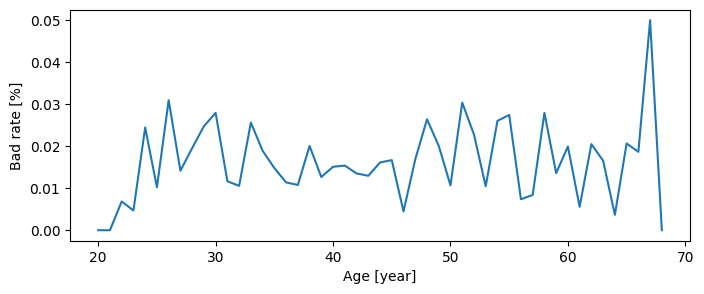

In [8]:
df_ = train_df.copy()
df_['Age'] = -df_['DAYS_BIRTH']//365
byage = df_.groupby('Age')['STATUS'].mean()

plt.figure(figsize=(8, 3))
plt.plot(byage)
plt.xlabel('Age [year]')
plt.ylabel('Bad rate [%]')
plt.show()

### 성별 신용

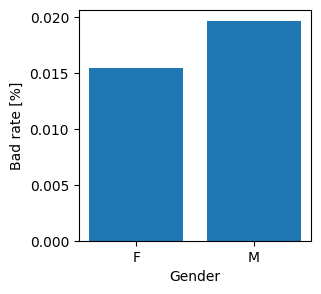

In [9]:
df_ = train_df.copy()
bygender = df_.groupby('CODE_GENDER')['STATUS'].mean()

plt.figure(figsize=(3, 3))
plt.bar(bygender.index, height=bygender)
plt.xlabel('Gender')
plt.ylabel('Bad rate [%]')
plt.show()

### 주수입원별 신용

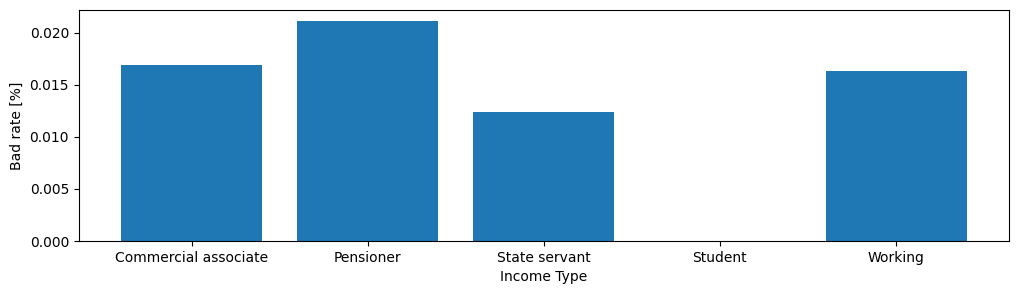

In [10]:
df_ = train_df.copy()
byincometype = df_.groupby('NAME_INCOME_TYPE')['STATUS'].mean()

plt.figure(figsize=(12, 3))
plt.bar(byincometype.index, height=byincometype)
plt.xlabel('Income Type')
plt.ylabel('Bad rate [%]')
plt.show()

### 신용별 수입

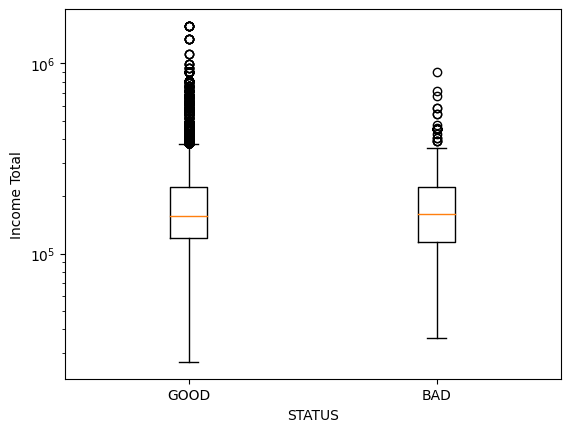

In [11]:
df_ = train_df.copy()
status_income = [df_['AMT_INCOME_TOTAL'][df_['STATUS'] == i] for i in [0, 1]]

plt.figure()
plt.boxplot(status_income, labels=['GOOD', 'BAD'])
plt.xlabel('STATUS')
plt.ylabel('Income Total')
plt.yscale('log')
plt.show()

### 상관분석

C:\Users\PC\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\PC\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\PC\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\PC\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


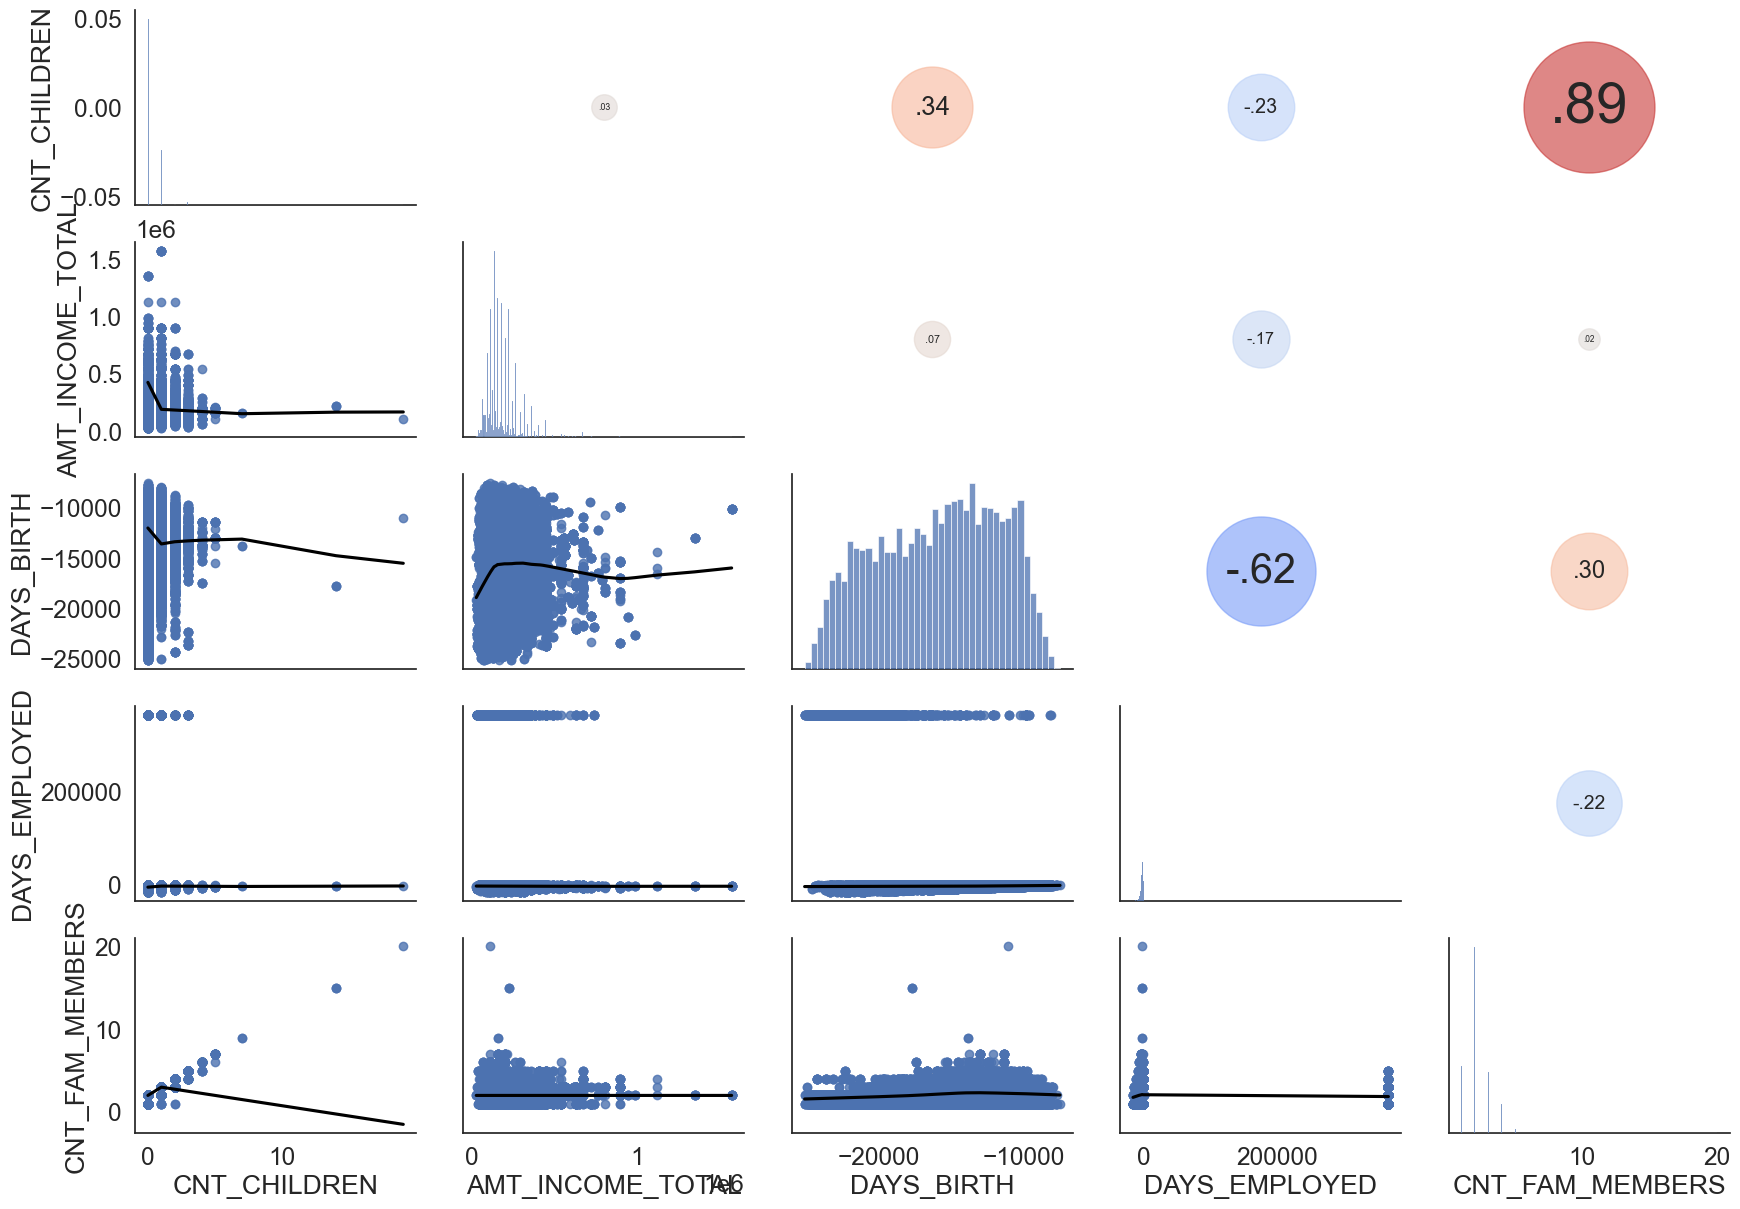

In [11]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

df_forCorr = train_df.loc[:, ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']]
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_forCorr, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

# 위 표에서 상관관계가 높은 것을 버림.

# 3. 특성 선택

In [12]:
df.drop(['CNT_CHILDREN', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE'], axis=1, inplace=True)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [13]:
X

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
ID,,,,,,,,
5008804,M,Y,Y,427500.0,Working,-12005,-4542,2.0
5008805,M,Y,Y,427500.0,Working,-12005,-4542,2.0
5008806,M,Y,Y,112500.0,Working,-21474,-1134,2.0
5008808,F,N,Y,270000.0,Commercial associate,-19110,-3051,1.0
5008809,F,N,Y,270000.0,Commercial associate,-19110,-3051,1.0
...,...,...,...,...,...,...,...,...
5150482,F,Y,Y,157500.0,Working,-10808,-1739,3.0
5150483,F,Y,Y,157500.0,Working,-10808,-1739,3.0
5150484,F,Y,Y,157500.0,Working,-10808,-1739,3.0


# 4. 전처리

In [13]:
# 성별, 차량 소유 여부, 부동산 소유 여부 인코딩
BinEnc_columns = X.columns[:3]
X[BinEnc_columns] = X[BinEnc_columns].applymap(lambda x: {'M':0, 'F':1, 'N':0, 'Y':1}[x])

# 주수입원 원핫 인코딩
X = pd.get_dummies(X, drop_first=True)

# 나이, 경력 변환
X[['DAYS_BIRTH', 'DAYS_EMPLOYED']] = X[['DAYS_BIRTH', 'DAYS_EMPLOYED']].applymap(lambda x: -x if x < 0 else 0)

# 소수 클래스 오버스케일링
sampler = SMOTE(sampling_strategy=0.2)
X, y = sampler.fit_resample(X, y)

X

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working
0,0,1,1,427500.000000,12005,4542,2.000000,0,0,0,1
1,0,1,1,427500.000000,12005,4542,2.000000,0,0,0,1
2,0,1,1,112500.000000,21474,1134,2.000000,0,0,0,1
3,1,0,1,270000.000000,19110,3051,1.000000,0,0,0,0
4,1,0,1,270000.000000,19110,3051,1.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
43004,0,0,0,398372.157585,10938,677,2.527146,0,0,0,1
43005,0,0,0,135000.000000,15192,2140,2.000000,0,0,0,0
43006,1,0,1,202500.000000,14318,3272,2.451404,0,0,0,0
43007,0,0,0,180000.000000,10479,1772,2.000000,0,0,0,0


In [14]:
# train/valid/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# 수입 표준화
std_scaler = StandardScaler()
X_train['AMT_INCOME_TOTAL'] = std_scaler.fit_transform(X_train['AMT_INCOME_TOTAL'].values.reshape(-1, 1))
X_val['AMT_INCOME_TOTAL'] = std_scaler.transform(X_val['AMT_INCOME_TOTAL'].values.reshape(-1, 1))
X_test['AMT_INCOME_TOTAL'] = std_scaler.transform(X_test['AMT_INCOME_TOTAL'].values.reshape(-1, 1))

# 생일, 경력, 가족 수 정규화
mM_scaler = MinMaxScaler()
mM_columns = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']
X_train[mM_columns] = mM_scaler.fit_transform(X_train[mM_columns])
X_val[mM_columns] = mM_scaler.transform(X_val[mM_columns])
X_test[mM_columns] = mM_scaler.transform(X_test[mM_columns])

X_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working
6354,0,1,1,0.156977,0.195493,0.026220,0.052632,0,0,0,1
39703,0,0,0,0.098837,0.733454,0.011519,0.052632,1,0,0,0
2522,0,1,1,0.055233,0.139444,0.102654,0.000000,0,0,0,1
16661,1,0,1,0.095930,0.903187,0.000000,0.052632,1,0,0,0
42077,1,0,0,0.069767,0.651022,0.661109,0.052632,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
15408,0,0,1,0.156977,0.489781,0.057277,0.052632,0,0,0,1
24450,0,0,0,0.034884,0.929231,0.000000,0.000000,1,0,0,0
42955,0,0,1,0.084302,0.577139,0.060459,0.052632,0,0,0,0
23921,1,0,0,0.200581,0.462492,0.011965,0.000000,0,0,0,1


# 5. 모델 선택

In [15]:
high_score = 0
best_model = None

for c in range(-3, 3):
    lr = LogisticRegression(solver='liblinear', C=10**c, random_state=1)
    model = lr.fit(X_train, y_train)
    p_val = lr.predict(X_val)
    score = f1_score(y_val, p_val)
    if score > high_score:
        high_score = score
        best_model = model
        
for i in range(6,25):
    forest = RandomForestClassifier(criterion='gini', max_depth=i, n_estimators=300, random_state=1, n_jobs=-1)
    model = forest.fit(X_train, y_train)
    p_val = forest.predict(X_val)
    score = f1_score(y_val, p_val)
    if score > high_score:
        high_score = score
        best_model = model

print('Best F1-score:', high_score)
best_model

Best F1-score: 0.9092511013215859


RandomForestClassifier(max_depth=22, n_estimators=300, n_jobs=-1,
                       random_state=1)

In [16]:
# 모델 평가
p_test = best_model.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))

F1-score: 0.9115357395612171
[[7064   70]
 [ 180 1288]]


## 혼동행렬
### 좌상단 우하단 맞은 것
### 좌하단 우상단 틀린 것